## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Data Creation

In [3]:
num_samples = 100

In [4]:
X = np.ones((num_samples,2))
X[:,0] = np.random.uniform(-1.,1.,num_samples)

In [5]:
a = np.array([5,7])
Y = X.dot(a) + np.random.rand(num_samples)

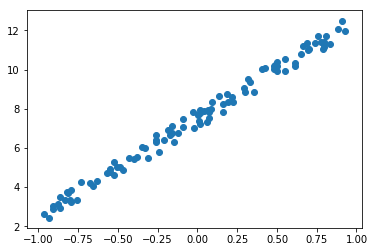

In [6]:
plt.scatter(X[:,0],Y)

## Plotting

In [7]:
from mpl_toolkits import mplot3d

In [8]:
def get_loss(a0,a1):
    theta = np.array([a0,a1])
    Y_hat = X.dot(theta)
    return mse(Y_hat,Y)
get_loss = np.vectorize(get_loss)

In [9]:
def mse(Y,Y_hat):
    return np.mean(np.square(Y - Y_hat),axis=0)

In [10]:
a0_range = np.linspace(-10,30,50)
a1_range = np.linspace(-10,30,50)
xx,yy = np.meshgrid(a0_range,a1_range)
loss_mesh = get_loss(xx,yy)

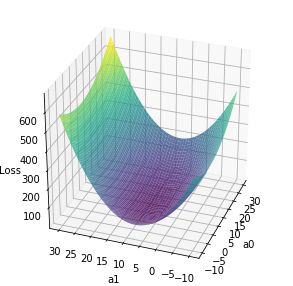

In [11]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, loss_mesh, cmap='viridis', alpha=0.8)
ax.set_xlabel('a0'); ax.set_ylabel('a1'); ax.set_zlabel('Loss')
ax.view_init(30, 200)

In [12]:
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from tqdm import tqdm_notebook
plt.rc('animation', html='html5')

In [13]:
epochs = 200

In [14]:
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, width_ratios=[1, 2.5])

# plot ground truth & model
ax0 = fig.add_subplot(gs[0,0])
ax0.scatter(X[:,0], Y, c='orange', label='Ground truth')
ax0.set_title('Ground truth & Model', fontsize=16)
line0, = ax0.plot([], [], label='Model')
ax0.legend(loc='lower right')

# plot loss 
ax1 = fig.add_subplot(gs[:,1], projection='3d')
ax1.set_title('Loss', fontsize=16, pad=20)
ax1.plot_surface(xx, yy, loss_mesh, cmap='viridis', alpha=0.8)
ax1.plot3D([a[0]], [a[1]], [0], c='r', marker='x', markersize=10, 
           label='Global minimum', linewidth=0)
line1, = ax1.plot3D([], [], [], c='r', marker='o', alpha=1, label='loss')
ax1.set_xlabel('a0'); ax1.set_ylabel('a1'); ax1.set_zlabel('Loss')
ax1.view_init(30, 200)
ax1.legend()

# plot weights & loss
ax2 = fig.add_subplot(gs[1,0])
ax2.set_title('Weights & Loss', fontsize=16)
line2, = ax2.plot([],[], label='a0')
line3, = ax2.plot([],[], label='a1')
ax2.set_ylim(0, 30)
ax2.set_xlim(0, epochs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('weights')
ax3 = ax2.twinx()
line4, = ax3.plot([],[], label='loss', c='r')
ax3.set_ylabel('loss')
ax3.set_ybound(0, 300)

ax2.legend((line2, line3, line4), ('a0', 'a1', 'loss'), loc='center right')


fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.close()

def animate(i):
    line0.set_data(X[:,0], (X.dot(rec_wgts[i])))
    line1.set_data(rec_wgts[:i+1,0], rec_wgts[:i+1,1])
    line1.set_3d_properties(rec_loss[:i+1])
    epochs = np.arange(i+1)
    line2.set_data(epochs, rec_wgts[:i+1, 0])
    line3.set_data(epochs, rec_wgts[:i+1, 1])
    line4.set_data(epochs, rec_loss[:i+1])
    return line0, line1, line2, line3, line4, ttl

## Training Loop

In [15]:
alpha = 0.1
a0 = 28.
a1 = 28.

In [16]:
def train(gd_func,a0,a1):
    recorder = []
    theta = np.array([a0,a1])
    for epoch in np.arange(epochs):
        val = gd_func(theta,alpha)
        if type(val) is tuple:
            recorder.append(val)
        else :
            recorder.extend(val)
    rec_wgts, rec_loss = [list(o) for o in zip(*recorder)]
    rec_wgts = np.stack(rec_wgts)
    return rec_wgts, rec_loss

## Batch Gradient Descent 

In [17]:
def gd(theta,alpha):
    Y_hat = X.dot(theta)
    loss = mse(Y_hat,Y)
    prevtheta = theta.copy()
    thetagrad = np.mean(X*((Y_hat - Y).reshape(-1,1)),axis=0)
    theta -= thetagrad*alpha
    return prevtheta,loss

In [18]:
ttl = fig.suptitle('Batch Gradient Descent', fontsize=18)
rec_wgts,rec_loss = train(gd,a0,a1)
animation.FuncAnimation(fig, animate, tqdm_notebook(range(epochs)), interval=30)

## Stochastic Gradient Descent

In [19]:
def sgd(theta,alpha):
    rl = []
    shuffled_i = np.random.permutation(np.arange(X.shape[0]))
    X_shuff = X[shuffled_i]
    Y_shuff = Y[shuffled_i]
    for i in np.arange(X.shape[0]):
        Yi_hat = X_shuff[i].dot(theta)
        loss= (Yi_hat - Y_shuff[i])**2
        prevtheta = theta.copy()
        thetagrad = X_shuff[i]*(Yi_hat - Y_shuff[i])
        theta -= thetagrad*alpha
        rl.append((prevtheta,loss))
    return rl

In [20]:
ttl = fig.suptitle('SGD', fontsize=22)
rec_wgts,rec_loss = train(sgd,a0,a1)
animation.FuncAnimation(fig, animate, tqdm_notebook(range(epochs)), interval=30)

## Mini-Batch Gradient Descent

In [21]:
def mb_gd(theta,alpha,bs = 10):
    rl = []
    shuffled_i = np.random.permutation(np.arange(X.shape[0]))
    X_shuff = X[shuffled_i]
    Y_shuff = Y[shuffled_i]
    for si in np.arange(X.shape[0]/bs):
        si *= bs
        ei = si + bs
        idxs = np.arange(si,ei)
        idxs = list(map(int,idxs))
        Y_idxs_hat = X_shuff[idxs].dot(theta)
        loss = mse(Y_idxs_hat,Y_shuff[idxs])
        prevtheta = theta.copy()
        thetagrad = np.mean(X_shuff[idxs]*((Y_idxs_hat - Y_shuff[idxs]).reshape(-1,1)),axis=0)
        theta -= thetagrad*alpha
        rl.append((prevtheta,loss))
    return rl

In [22]:
ttl = fig.suptitle('Mini Batch GD', fontsize=22)
rec_wgts,rec_loss = train(mb_gd,a0,a1)
animation.FuncAnimation(fig, animate, tqdm_notebook(range(epochs)), interval=30)